In [10]:
from modules import EncoderNet,DecoderNet,DiscriminatorNet_reconstruction,GeneratorNet
from network import transformNet

import matplotlib.pylab as plt
#import resnet
#import invresnet
from dataload import load_data ,batchfy 
from torchsummary import summary
import torch
from torch import nn,optim
import numpy as np
import random
import torch
import time
from torchvision import transforms, utils
TIMEOUT=300

In [11]:


%load_ext autoreload
%autoreload 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
Encoder=torch.load("Encoder_64batch.h")
Decoder=torch.load("Decoder_64batch.h")
#Encoder=resnet.resnet18()
#Encoder=Encoder.to(device)


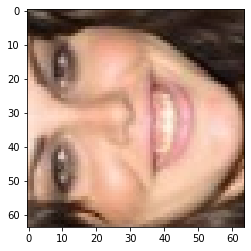

In [13]:
train_load,test_load=batchfy(batch_size=100)
show_img=iter(train_load)
for batch_i, (real_images, gender,glasses) in enumerate(train_load):
    debug=real_images[0]
    plt.imshow((debug.numpy().transpose((1, 2, 0))*0.5)+0.5)
    break

In [14]:
phi=transformNet.phi()
phi.to(device)

invphi=transformNet.phi(inv=True)
invphi.to(device)

#Transform=transformNet.full_phi(phi,invphi)

phi(
  (fc1): Linear(in_features=99, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=99, bias=True)
)

In [15]:
opt_phi = optim.Adam(phi.parameters(), lr=0.0001, betas=(0.9, 0.999))
opt_invphi = optim.Adam(invphi.parameters(), lr=0.001, betas=(0.9, 0.999))
#criterion = nn.BCELoss()

In [16]:
import itertools

params = [phi.parameters(), invphi.parameters()]

opt_transform=optim.Adam(itertools.chain(*params),lr=0.001,betas=(0.9,0.999))

In [17]:
def TripleletLoss(batch,targetAttribute):
    def triplet(value, positive, negative, margin=0.2) : 
        d = nn.PairwiseDistance(p=2)
        distance = d(value, positive) - d(value, negative) + margin 
        loss = torch.mean(torch.max(distance, torch.zeros_like(distance))) 
        return loss
    
    def findtriplet(src,attribute):
        timeout_start = time.time()
        index_list=np.arange(len(attribute)).tolist()
        rand=random.sample(index_list,len(attribute))
        for i,posindex in enumerate(rand):
            if attribute[src]==attribute[posindex]:
                if src != posindex:
                        break      
            if i==len(attribute)-1:
                posindex=src            
        rand=random.sample(index_list,len(attribute))                
        for i,negindex in enumerate(rand):
            if(attribute[src] !=attribute[negindex]):
                break   
            if i==len(attribute)-1:
                negindex=src
                
        return posindex,negindex
    loss=0
    pos_pair=None
    for i,value in enumerate(batch):
        posindex,negindex=findtriplet(i,targetAttribute)

        if not i:

            pos_pair=batch[posindex].unsqueeze(0)
            neg_pair=batch[negindex].unsqueeze(0)
        else:
            pos_pair=torch.cat((pos_pair,batch[posindex].unsqueeze(0)),0)
            neg_pair=torch.cat((neg_pair,batch[negindex].unsqueeze(0)),0)


    return triplet(batch,pos_pair,neg_pair)

def reconstruction_loss(z,z_tilde,optimizer):
    loss = nn.L1Loss()
    optimizer.zero_grad()
    error_recons=loss(z,z_tilde)
    error_recons.backward(retain_graph=True)
    optimizer.step()
    return error_recons

def concat(z_list):
    return torch.cat((z_list[0],z_list[1],z_list[2]),1)

def cyclic_loss(z1,z2,z3,true_glasses,true_gender,opt_transform):
    batch_size=z1.size(0)
    swapped_pos=torch.randperm(batch_size)   
    z1_hat = z1[swapped_pos]   #Permutation
    true_glasses=true_glasses[swapped_pos]  
    swapped_pos=torch.randperm(batch_size)
    true_gender=true_glasses[swapped_pos]
    z2_hat=z2[swapped_pos]
    swapped_pos=torch.randperm(batch_size)
    z3_hat=z3[swapped_pos]
    true_gender=true_glasses[true_glasses]
    z_aster=torch.cat((z1_hat,z2_hat,z3),1)
    recontructed_z_aster=concat(phi(Encoder(Decoder(invphi(z_aster)))))
    #Cycle_Consistency,Loss                 
    opt_transform.zero_grad()
    loss = nn.MSELoss()                                                     
    consistency_loss = loss(z_aster,recontructed_z_aster)
    consistency_loss.backward()
    opt_transform.step()
    
    
   # opt_transform.zero_grad()
    #augmentation_loss =TripleletLoss(z1_hat,true_glasses)# + TripleletLoss(z2_hat,true_gender)
    #print(augmentation_loss)
  #  augmenstation_loss.backward()
   # opt_transform.step()
    return consistency_loss #+augmentation_loss       



In [18]:
def train(Encoder,phi,invphi,train_load,num_epochs=40):
    t_start = time.time()
    Encoder.eval()
    Decoder.eval()
    phi.train()
    invphi.train()
    for epoch in range(num_epochs):
        print("Epoch:", epoch)
        for batch_i, (real_images, gender,glasses) in enumerate(train_load):
            batch_size = real_images.size(0)
            real_images=real_images.to(device,dtype=torch.float)
            latent_vector=Encoder(real_images).detach()
            glass_vector,gender_vector,remain=phi(latent_vector)
            
            #Reconstruction Loss
            z_tilde=invphi(torch.cat((glass_vector,gender_vector,remain),1))
            loss_reconstruction=reconstruction_loss(latent_vector,z_tilde,opt_transform)
            
            
            #Task Loss
            opt_phi.zero_grad()       
            loss=TripleletLoss(glass_vector,glasses) +    TripleletLoss(gender_vector,gender)  
            #print(loss)
            loss.backward()
            opt_phi.step()
            
            glass_vector=glass_vector.detach()
            gender_vector=gender_vector.detach()
            remain=remain.detach()

            
            #Cyclic Loss
            loss_cycle=cyclic_loss(glass_vector,gender_vector,remain,glasses,gender,opt_transform)
            
            if (batch_i) % 300 == 0:
                print("Batch: ", batch_i)
                print("Task Loss: ", loss.item())
                print("Reconstruction Loss: ",loss_reconstruction.item())
                print("Cyclic Loss: ",loss_cycle.item())
        t_end = time.time()
        duration_avg = (t_end - t_start) / (epoch + 1.0)
        print("Elapsed Time: ",duration_avg)
        #torch.save(phi,'Phi.h')
    return 

In [20]:
train(Encoder,phi,invphi,train_load,num_epochs=40)




Epoch: 0
Batch:  0
Task Loss:  0.647313117980957
Reconstruction Loss:  0.13472586870193481
Cyclic Loss:  0.025652391836047173
Batch:  300
Task Loss:  0.35863977670669556
Reconstruction Loss:  0.03567996993660927
Cyclic Loss:  0.008588036522269249
Batch:  600
Task Loss:  0.3992929458618164
Reconstruction Loss:  0.03635320067405701
Cyclic Loss:  0.008220270276069641
Batch:  900
Task Loss:  0.25084248185157776
Reconstruction Loss:  0.03142152354121208
Cyclic Loss:  0.007709841709583998
Batch:  1200
Task Loss:  0.2544933259487152
Reconstruction Loss:  0.03300273045897484
Cyclic Loss:  0.0076814149506390095
Batch:  1500
Task Loss:  0.17253053188323975
Reconstruction Loss:  0.03056464157998562
Cyclic Loss:  0.007671115919947624
Elapsed Time:  521.5809080600739
Epoch: 1
Batch:  0
Task Loss:  0.2644643485546112
Reconstruction Loss:  0.030414987355470657
Cyclic Loss:  0.007866722531616688
Batch:  300
Task Loss:  0.2279462218284607
Reconstruction Loss:  0.02879204973578453
Cyclic Loss:  0.007897

In [ ]:
glass_vector

In [ ]:
test=torch.randperm(100)